<a href="https://colab.research.google.com/github/dvarelaj/nlp-miniproyecto-icesi/blob/main/analisis_sentimientos_quejas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.matcher import Matcher
from collections import Counter
import spacy.cli
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Se hace etiquetado manual sobre la muestra de quejas seleccionadas para correr el modelo y poder comparar.

In [3]:
# URL de GitHub
url_datos = 'https://raw.githubusercontent.com/dvarelaj/nlp-miniproyecto-icesi/main/quejas_anonimizadas_muestra_etiqueta.csv'
df = pd.read_csv(url_datos, delimiter=';')

Luego, hagamos algo de limpieza, vamos a remover nulos y valores vacíos:

In [4]:
# Limpieza básica
df.dropna(subset=['descripcion_anonimizada'], inplace=True)
df = df[df['descripcion_anonimizada'].str.strip() != '']

print(f"Total de quejas para analizar: {len(df)}")

Total de quejas para analizar: 101


En lugar de nltk.vader, usaremos un analizador profesional para español ya que nuestro archivo de datos tiene quejas y peticiones en español.

In [5]:
#!pip install pysentimiento

In [6]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicamos el análisis a nuestras quejas
df['sentiment_results'] = df['descripcion_anonimizada'].apply(lambda x: analyzer.predict(x))
df['prediction'] = df['sentiment_results'].apply(lambda r: r.output)
df['compound_score'] = df['sentiment_results'].apply(lambda r: r.probas['NEG'] * -1 if r.output == 'NEG' else r.probas['POS'])

df[['descripcion_anonimizada', 'prediction']].head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

,descripcion_anonimizada,prediction
0,usuaria se comunica porque requiere ingresar a...,NEG
1,empresa cc : [ID_ANONIMIZADO] ingresa con usua...,NEG
2,se comunica porque esta ingresando al portal p...,NEU
3,nehcesito afiliar a unas personas pero me sale...,NEG
4,id chat : [ID_ANONIMIZADO] canal de atencion w...,NEG


In [7]:
# Conteo de los resultados obtenidos por el modelo
conteo_sentimientos = df['prediction'].value_counts()
print(conteo_sentimientos)

prediction
NEG    71
NEU    30
Name: count, dtype: int64


In [8]:
# Predicciones del modelo
y_pred = [p.lower() for p in df['prediction'].tolist()]

# Obtener las etiquetas verdaderas
y_true = df['y_true'].tolist()

# Generar el reporte (requires y_true)
reporte = classification_report(y_true, y_pred)
print("### Reporte de Clasificación ###")
print(reporte)

# Calcular exactitud total (requires y_true)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy Total: {accuracy:.2f}")

### Reporte de Clasificación ###
              precision    recall  f1-score   support

         neg       0.86      0.76      0.81        80
         neu       0.37      0.52      0.43        21

    accuracy                           0.71       101
   macro avg       0.61      0.64      0.62       101
weighted avg       0.76      0.71      0.73       101

Accuracy Total: 0.71


REVISAR
Interpretación de Métricas:

Sesgo hacia Negativo: Se observa que el modelo tiene un alto Recall para la clase neg, identificando casi todas las quejas de falla técnica.

Confusión en Neutrales: Existe una tendencia del modelo a clasificar casos neu (consultas de mantenimiento o trámites) como neg. Esto ocurre porque palabras como "mantenimiento" o "no carga" tienen una carga semántica negativa para el modelo, aunque el usuario esté informando una situación técnica sin molestia explícita.

Desbalance: Al ser un corpus de quejas reales, la ausencia de la clase pos dificulta la evaluación de esa categoría, lo cual es un comportamiento esperado en entornos de soporte técnico de una ARL.

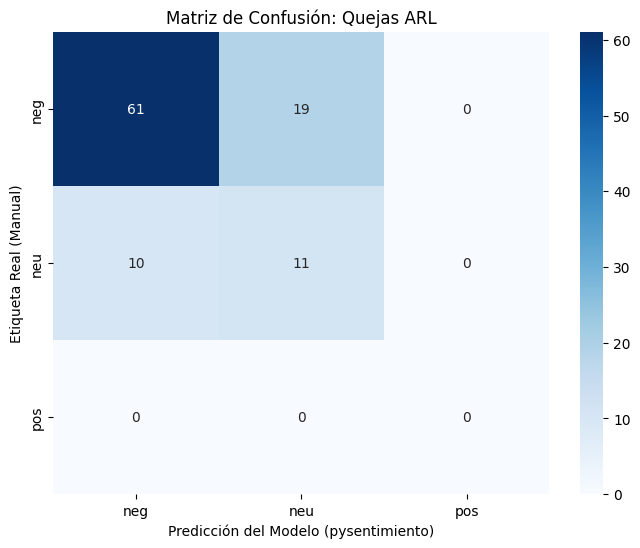

In [9]:
# Crear la matriz de confusión
labels = ['neg', 'neu', 'pos']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Graficar
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción del Modelo (pysentimiento)')
plt.ylabel('Etiqueta Real (Manual)')
plt.title('Matriz de Confusión: Quejas ARL')
plt.show()